In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.nn.utils.parametrize as parametrize
from tqdm import tqdm

## Hyperparameters

In [2]:
BATCH_SIZE = 200

TEST_SIZE = 0.2

N_EPOCH = 2
LEARNING_RATES = 0.001

torch.manual_seed(689)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Dataset preparations

In [3]:
from automata import DFA, TorchData, AutomataRNN, ParametrizeRNN
from datas import principal

In [4]:
even, fix, unique = principal(even=True, fix=True, unique=True)

Generate dataset 'even'...
Done! in 3.9854 sec
Generate 'fix'...
Done! in 3.5392 sec
Generate 'unique'...
Done! in 3.3797 sec


In [5]:
def makeloader(automaton:DFA):
    train, test = random_split(TorchData(automaton), [1-TEST_SIZE, TEST_SIZE])

    train = DataLoader(train, BATCH_SIZE, shuffle=True)
    test = next(iter(DataLoader(test, len(test))))

    return train, test
    

evenloader, testeven = makeloader(even)
fixloader, testfix = makeloader(fix)
uniqueloader, testunique = makeloader(unique)

## RNN training

In [6]:
def parametrizevsnot(automaton:DFA, loss = nn.BCELoss(), optimizer = torch.optim.Adam, returnautomat=False):
    trainloader, test = makeloader(automaton)

    noparam = AutomataRNN(automaton, device=device).to(device)
    optim = optimizer(noparam.parameters(), lr=LEARNING_RATES)
    optim.zero_grad()

    losslistnoinit = list()

    for epoch in range(N_EPOCH):
        trainer = iter(trainloader)
        for _ in tqdm(range(len(trainloader)), desc=f"Epoch {epoch+1}...", ncols=75):
            words, lengths, labels = next(trainer)
            labels = labels.to(dtype = torch.float32)

            out = noparam(words, lengths)

            losslistnoinit.append(loss(out, labels))
            losslistnoinit[-1].backward()

            optim.step()
            optim.zero_grad()

        with torch.no_grad():
            predictions = noparam.predict(test[0], test[1])
            acc = torch.sum(predictions == test[2].reshape(-1), dim=0) * 100 / len(test[2])
            print(f"Done! Trainloss: {losslistnoinit[-1]:.6f}, Test accuracy: {acc:.4f}")

    print("\nNon parametrized RNN done!\n")

    withparam = ParametrizeRNN(automaton, device=device).to(device)

    optim = optimizer(withparam.parameters(), lr=LEARNING_RATES)
    optim.zero_grad()

    losslistinit = list()

    for epoch in range(N_EPOCH):
        trainer = iter(trainloader)
        for _ in tqdm(range(len(trainloader)), desc=f"Epoch {epoch+1}...", ncols=75):
            words, lengths, labels = next(trainer)
            labels = labels.to(dtype = torch.float32)

            out = withparam(words, lengths)

            losslistinit.append(loss(out, labels))
            losslistinit[-1].backward()

            optim.step()
            optim.zero_grad()

        with torch.no_grad():
            predictions = withparam.predict(test[0], test[1])
            acc = torch.sum(predictions == test[2].reshape(-1), dim=0) * 100 / len(test[2])
            print(f"Done! Trainloss: {losslistinit[-1]:.6f}, Test accuracy: {acc:.4f}")

    print("\nParametrized RNN done!")
    if returnautomat:
        return (losslistnoinit, noparam), (losslistinit, withparam)
    else:
        return losslistnoinit, losslistinit
            

### Even

In [7]:
evennop, evenp = parametrizevsnot(even)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 37.55it/s]


Done! Trainloss: 0.700114, Test accuracy: 51.9500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:00<00:00, 41.20it/s]


Done! Trainloss: 0.700668, Test accuracy: 51.9000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 37.98it/s]


Done! Trainloss: 0.694074, Test accuracy: 52.0000


Epoch 2...: 100%|██████████████████████████| 40/40 [00:00<00:00, 45.94it/s]

Done! Trainloss: 0.694512, Test accuracy: 52.0000

Parametrized RNN done!


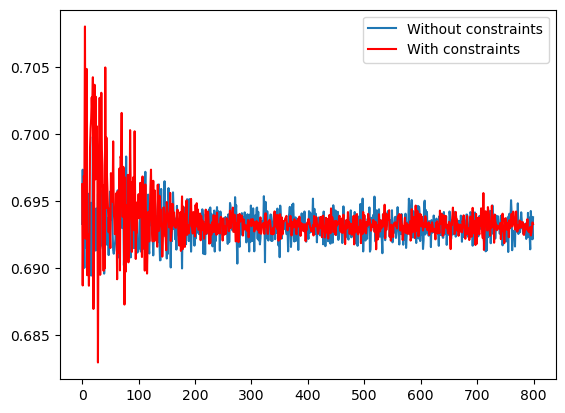

In [25]:
with torch.no_grad():
    plt.plot(evennop, label = "Without constraints")
    plt.plot(evenp, "r", label="With constraints")
    plt.legend()
    plt.show()
    

### Sink

In [19]:
(sinknop, sinkRNN), (sinkp, _) = parametrizevsnot(sink, returnautomat=True)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.64it/s]


Done! Trainloss: 0.636755, Test accuracy: 66.1500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.34it/s]


Done! Trainloss: 0.513982, Test accuracy: 87.8500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.97it/s]


Done! Trainloss: 0.357686, Test accuracy: 92.6000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 30.32it/s]


Done! Trainloss: 0.256723, Test accuracy: 99.3000


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.65it/s]


Done! Trainloss: 0.177600, Test accuracy: 100.0000


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.07it/s]


Done! Trainloss: 0.132778, Test accuracy: 100.0000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.47it/s]


Done! Trainloss: 0.099441, Test accuracy: 100.0000


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.45it/s]


Done! Trainloss: 0.084540, Test accuracy: 100.0000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.05it/s]


Done! Trainloss: 0.067658, Test accuracy: 100.0000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.07it/s]


Done! Trainloss: 0.054356, Test accuracy: 100.0000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 29.96it/s]


Done! Trainloss: 0.040657, Test accuracy: 100.0000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.40it/s]


Done! Trainloss: 0.033858, Test accuracy: 100.0000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.72it/s]


Done! Trainloss: 0.029050, Test accuracy: 100.0000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.27it/s]


Done! Trainloss: 0.031387, Test accuracy: 100.0000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.51it/s]


Done! Trainloss: 0.034508, Test accuracy: 100.0000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.74it/s]


Done! Trainloss: 0.019761, Test accuracy: 100.0000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 22.02it/s]


Done! Trainloss: 0.020327, Test accuracy: 100.0000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 23.81it/s]


Done! Trainloss: 0.012532, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.92it/s]


Done! Trainloss: 0.012972, Test accuracy: 100.0000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.98it/s]


Done! Trainloss: 0.021465, Test accuracy: 100.0000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 37.10it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.4500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.05it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.4500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 35.04it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.4500


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 36.64it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.4500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 36.87it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.4500


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.74it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.5000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.56it/s]


Done! Trainloss: 0.021465, Test accuracy: 93.8500


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 37.18it/s]


Done! Trainloss: 0.021465, Test accuracy: 96.6000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 36.68it/s]


Done! Trainloss: 0.021465, Test accuracy: 95.7500


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 37.54it/s]


Done! Trainloss: 0.021465, Test accuracy: 96.3000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 38.10it/s]


Done! Trainloss: 0.021465, Test accuracy: 97.2000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 37.00it/s]


Done! Trainloss: 0.021465, Test accuracy: 97.3000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.99it/s]


Done! Trainloss: 0.021465, Test accuracy: 97.4000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 37.09it/s]


Done! Trainloss: 0.021465, Test accuracy: 99.2500


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.89it/s]


Done! Trainloss: 0.021465, Test accuracy: 99.3500


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 21.53it/s]


Done! Trainloss: 0.021465, Test accuracy: 99.7000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.08it/s]


Done! Trainloss: 0.021465, Test accuracy: 99.9000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.22it/s]


Done! Trainloss: 0.021465, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.44it/s]


Done! Trainloss: 0.021465, Test accuracy: 99.9000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 28.57it/s]


Done! Trainloss: 0.021465, Test accuracy: 100.0000

Parametrized RNN done!


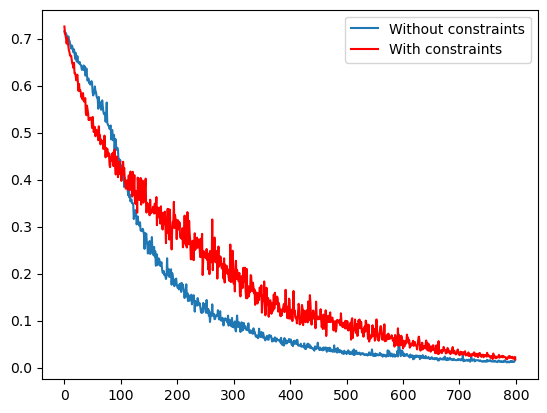

In [20]:
with torch.no_grad():
    plt.plot(sinknop, label = "Without constraints")
    plt.plot(sinkp, "r", label="With constraints")
    plt.legend()
    plt.show()
    

In [21]:
sink.probas = "equal"

sink.dataset(10000, meanlen = 12, max_try = 10000, random_state=690)

sinkmoretest = next(iter(DataLoader(TorchData(sink), 10000)))

with torch.no_grad():
    predictions = sinkRNN.predict(sinkmoretest[0], sinkmoretest[1])
    acc = torch.sum(predictions == sinkmoretest[2].reshape(-1), dim=0) * 100 / len(sinkmoretest[2])
    print(f"Test accuracy: {acc:.4f}")

/home/mt-ubu2/Documents/Internship/RNN_autmata/automata.py:325: UserWarning: `max_try` limit reach. Final prop = 0.0002
  warn(f"`max_try` limit reach. Final prop = {sum(labels)/len(labels)}")


Test accuracy: 98.3000


## Fix

In [22]:
fixnop, fixp = parametrizevsnot(fix)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.31it/s]


Done! Trainloss: 0.396168, Test accuracy: 94.5500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.15it/s]


Done! Trainloss: 0.195281, Test accuracy: 94.5500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.28it/s]


Done! Trainloss: 0.115013, Test accuracy: 98.6000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 38.09it/s]


Done! Trainloss: 0.052679, Test accuracy: 100.0000


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 31.72it/s]


Done! Trainloss: 0.026220, Test accuracy: 100.0000


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 31.37it/s]


Done! Trainloss: 0.017918, Test accuracy: 100.0000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.01it/s]


Done! Trainloss: 0.011749, Test accuracy: 100.0000


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.04it/s]


Done! Trainloss: 0.009931, Test accuracy: 100.0000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 35.76it/s]


Done! Trainloss: 0.007520, Test accuracy: 100.0000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.00it/s]


Done! Trainloss: 0.006163, Test accuracy: 100.0000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.53it/s]


Done! Trainloss: 0.005634, Test accuracy: 100.0000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 31.78it/s]


Done! Trainloss: 0.004485, Test accuracy: 100.0000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 37.05it/s]


Done! Trainloss: 0.003897, Test accuracy: 100.0000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.56it/s]


Done! Trainloss: 0.003409, Test accuracy: 100.0000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.10it/s]


Done! Trainloss: 0.002996, Test accuracy: 100.0000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 36.27it/s]


Done! Trainloss: 0.002961, Test accuracy: 100.0000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.11it/s]


Done! Trainloss: 0.002449, Test accuracy: 100.0000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.52it/s]


Done! Trainloss: 0.002182, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.94it/s]


Done! Trainloss: 0.002020, Test accuracy: 100.0000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 31.49it/s]


Done! Trainloss: 0.001792, Test accuracy: 100.0000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 35.41it/s]


Done! Trainloss: 0.696723, Test accuracy: 52.9500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.39it/s]


Done! Trainloss: 0.663784, Test accuracy: 69.5500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.30it/s]


Done! Trainloss: 0.444811, Test accuracy: 88.9000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 31.48it/s]


Done! Trainloss: 0.268627, Test accuracy: 89.9000


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 30.23it/s]


Done! Trainloss: 0.246331, Test accuracy: 89.9000


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.51it/s]


Done! Trainloss: 0.272405, Test accuracy: 90.7500


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.54it/s]


Done! Trainloss: 0.235122, Test accuracy: 91.6500


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 31.88it/s]


Done! Trainloss: 0.206864, Test accuracy: 94.7000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 35.54it/s]


Done! Trainloss: 0.168924, Test accuracy: 95.5000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.03it/s]


Done! Trainloss: 0.222031, Test accuracy: 95.6500


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.31it/s]


Done! Trainloss: 0.161384, Test accuracy: 95.7000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.97it/s]


Done! Trainloss: 0.103237, Test accuracy: 95.7000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.40it/s]


Done! Trainloss: 0.100993, Test accuracy: 96.1000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 26.92it/s]


Done! Trainloss: 0.053986, Test accuracy: 98.8000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.03it/s]


Done! Trainloss: 0.050713, Test accuracy: 99.0500


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.39it/s]


Done! Trainloss: 0.045888, Test accuracy: 99.0500


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 26.38it/s]


Done! Trainloss: 0.034282, Test accuracy: 99.2500


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 35.11it/s]


Done! Trainloss: 0.021861, Test accuracy: 99.4000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.24it/s]


Done! Trainloss: 0.037687, Test accuracy: 99.7000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 27.94it/s]


Done! Trainloss: 0.021381, Test accuracy: 99.8500

Parametrized RNN done!


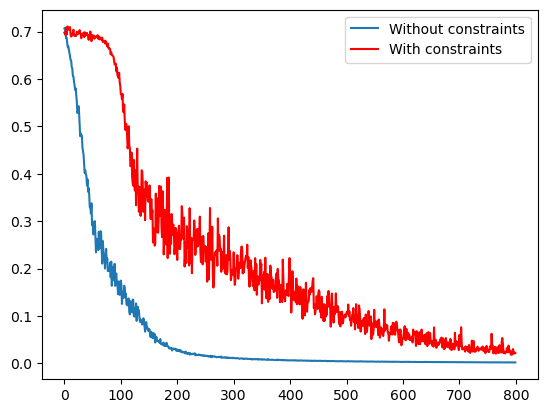

In [23]:
with torch.no_grad():
    plt.plot(fixnop, label = "Without constraints")
    plt.plot(fixp, "r", label="With constraints")
    plt.legend()
    plt.show()
    

## Unique

In [8]:
(uniquenop, uniquenop_model), (uniquep, uniquep_model) = parametrizevsnot(unique, returnautomat=True)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.13it/s]


Done! Trainloss: 0.697392, Test accuracy: 43.2500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 31.22it/s]


Done! Trainloss: 0.693486, Test accuracy: 51.7000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 25.61it/s]


Done! Trainloss: 0.692910, Test accuracy: 49.1000


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 25.69it/s]


Done! Trainloss: 0.692840, Test accuracy: 49.1000

Parametrized RNN done!


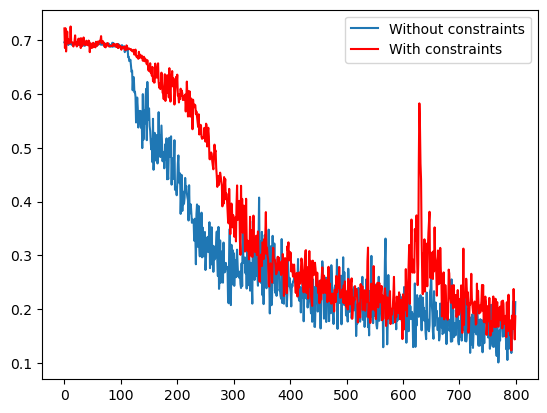

In [29]:
with torch.no_grad():
    plt.plot(uniquenop, label = "Without constraints")
    plt.plot(uniquep, "r", label="With constraints")
    plt.legend()
    plt.show()
    

In [9]:
uniquep_model.state_dict()

OrderedDict([('rnn.parametrizations.weight_hh_l0.original',
              tensor([[-0.1373,  0.0000,  0.0000,  0.0000, -0.0719,  0.0000,  0.0000,  0.0000,
                        0.0983,  0.0000,  0.0000,  0.0000, -0.0124,  0.0000,  0.0000,  0.0000,
                        0.0874,  0.0000,  0.0000,  0.0000,  0.1076,  0.0000,  0.0000,  0.0000],
                      [-0.1041,  0.0000,  0.0000,  0.0000, -0.1358,  0.0000,  0.0000,  0.0000,
                       -0.1165,  0.0000,  0.0000,  0.0000,  0.1225,  0.0000,  0.0000,  0.0000,
                        0.0817,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000],
                      [-0.0402,  0.0000,  0.0000,  0.0000, -0.0784,  0.0000,  0.0000,  0.0000,
                       -0.0390,  0.0000,  0.0000,  0.0000, -0.1444,  0.0000,  0.0000,  0.0000,
                       -0.1381,  0.0000,  0.0000,  0.0000, -0.0394,  0.0000,  0.0000,  0.0000],
                      [-0.0163,  0.0000,  0.0000,  0.0000,  0.0519,  0.0000,  0.00

In [21]:
uniquep_model.rnn.all_weights#parametrizations["weight_hh_l0"][0].change_base

[[tensor([[0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0657, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0657],
          [0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0657, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0657],
          [0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0657, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0657],
          [0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0657, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0657],
          [0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0657, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0657],
          [0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.065